In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
# --------------------------------------------------------
# Copyright (c) 2019 University of Twente.
# Licensed under The MIT License [see LICENSE for details]
# Written by Ye Lyu.
# --------------------------------------------------------

import datasets
import datasets.imagenet
import os, sys
from datasets.imdb import imdb
import xml.dom.minidom as minidom
import numpy as np
import numpy.random as npr
import scipy.sparse
import scipy.io as sio
import subprocess
import pdb
import pickle
import random

try:
    xrange          # Python 2
except NameError:
    xrange = range  # Python 3

In [71]:


class imagenetVID(imdb):
    def __init__(self, image_set, devkit_path, data_path, gap = 2):
        imdb.__init__(self, 'imagenetVID_'+ image_set)
        self._image_set = image_set
        self._devkit_path = devkit_path
        self._data_path = data_path
        synsets_video = sio.loadmat(os.path.join(self._devkit_path, 'data', 'meta_vid.mat'))
        self._gap = gap
        self._classes = ('__background__',)
        self._wnid = (0,)
        
        for i in xrange(30):
            self._classes = self._classes + (synsets_video['synsets'][0][i][2][0],)
            self._wnid = self._wnid + (synsets_video['synsets'][0][i][1][0],)

        self._wnid_to_ind = dict(zip(self._wnid, xrange(31)))
        self._class_to_ind = dict(zip(self._classes, xrange(31)))

        self._image_ext = ['.JPEG']
        
        # structured_indexes hold indexes in structure of [cat..[vid..[imgs]]]
        self._image_index, self._structured_indexes = self._load_image_set_index()

        # Default to roidb handler
        self._roidb_handler = self.gt_roidb

        # Specific config options
        self.config = {'cleanup'  : True,
                       'use_salt' : True,
                       'top_k'    : 2000}

        assert os.path.exists(self._devkit_path), 'Devkit path does not exist: {}'.format(self._devkit_path)
        assert os.path.exists(self._data_path), 'Path does not exist: {}'.format(self._data_path)

    def image_path_at(self, i):
        """
        Return the absolute path to image i in the image sequence.
        """
        return self.image_path_from_index(self._image_index[i])

    def image_id_at(self, i):
        """
        Return the absolute path to image i in the image sequence.
        """
        return self._image_index[i]

    def image_path_from_index(self, index):
        """
        Construct an image path from the image's "index" identifier.
        """
        #print(index)
        #image_path = os.path.join(self._data_path, 'Data', self._image_set, index + self._image_ext[0])
        image_path = index + self._image_ext[0]
        #print(image_path)
        assert os.path.exists(image_path), 'path does not exist: {}'.format(image_path)
        return image_path

    def get_vids_for_category(self, cat_ind):
        """
        Get video number of the category.
        The first category starts from cat_ind 1.
        """
        assert cat_ind>0 and cat_ind<=31, 'cat_ind should be in range from [1,30]'
        vid_set_file = os.path.join(self._data_path, 'ImageSets', 'VID', 'train_' + str(cat_ind) + '.txt')
        tmp_index = []
        with open(vid_set_file) as f:
            tmp_index = [x.strip().split(' ')[0] for x in f.readlines()]
            for tmp in tmp_index:
                assert os.path.exists(self._data_path + '/Data/VID/train/' +tmp), ('Path not exists:%s')%(
                    self._data_path + '/Data/VID/train/' +tmp)
        return tmp_index
        
    def get_imgs_for_vid(self, cat_ind, vid_ind, isSorted=True):
        """
        Get images for video.
        """
        assert cat_ind>0 and cat_ind<=30, 'cat_ind should be in range from [1,30]'
        vid_set_file = os.path.join(self._data_path, 'ImageSets', 'VID', 'train_' + str(cat_ind) + '.txt')
        tmp_index = []
        with open(vid_set_file) as f:
            tmp_index = [x.strip().split(' ')[0] for x in f.readlines()]
        assert vid_ind>=0 and vid_ind<len(tmp_index)
        vid_dir = self._data_path + '/Data/VID/train/' + tmp_index[vid_ind]
        img_names = os.listdir(vid_dir)
        img_names = [os.path.join(vid_dir,name) for name in img_names]
        directory = os.path.dirname(img_names[0])
        for i in range(len(img_names)):
            assert os.path.exists(os.path.join(directory,'%06d.JPEG'%i)),'The image %s is missing.'%(os.path.join(directory,'%06d.JPEG'%i))
        if isSorted:
            return [os.path.join(directory,'%06d.JPEG'%i) for i in range(len(img_names))]
        else:
            return img_names
    
    def get_anns_for_imgs(self, imgs):
        return [self._load_imagenet_annotation(img) for img in imgs]

    def get_trackids_set_from_anns(self, anns):
        trackids = set()
        for ann in anns:
            obj_trackids = ann['trackid']
            for o_tid in obj_trackids:
                trackids.add(o_tid)
        return trackids
    
    def _load_image_set_index(self):
        '''
        Load all the image index.
        '''
        if self._image_set == 'train':
            image_set_file = os.path.join(self._data_path, 'ImageSets', 'trainr_VID_TRA.pkl')
            image_index = []
            if os.path.exists(image_set_file):
                with open(image_set_file, 'r') as f:
                    '''
                    data = f.readlines()
                    for line in data:
                        if line != '':
                            image_index.append(line)
                    '''
                    image_index,structured_indexes = pickle.load(f)
                    return image_index,structured_indexes

            # We use vid_indexes to contain all video folders for each category.
            vid_indexes = []
            for i in range(1,31):
                vid_set_file = os.path.join(self._data_path, 'ImageSets', 'VID', 'train_' + str(i) + '.txt')
                with open(vid_set_file) as f:
                    tmp_index = [x.strip() for x in f.readlines()]
                    vtmp_index = []
                    for line in tmp_index:
                        line = line.split(' ')
                        if line[1]=='1':
                            vtmp_index.append(self._data_path + '/Data/VID/train/' +line[0])
                        else:
                            print(line)
                            raise 'Please check your file list.'

                    vid_indexes.append(vtmp_index)
                    
            # list hold all video image indexes.
            image_indexes =[]
            structured_indexes = []
            idx_counter = 0
            for vid_idx in vid_indexes:
                cat_holder = []
                for vid_id in vid_idx:
                    vid_holder = []
                    flist = os.listdir(vid_id)
                    nfiles = len(flist)
                    for iid in range(self._gap//2, nfiles, self._gap):
                        image_indexes.append(os.path.join(vid_id, '%06d'%(iid)))
                        vid_holder.append(idx_counter)
                        idx_counter+=1
                    cat_holder.append(vid_holder)
                structured_indexes.append(cat_holder)
    
            with open(image_set_file, 'w') as f:
                '''
                for line in image_indexes:
                        f.write(line + '\n')
                '''
                pickle.dump((image_indexes,structured_indexes), f, pickle.HIGHEST_PROTOCOL)
            return image_indexes,structured_indexes
        else:
            image_set_file = os.path.join(self._data_path, 'ImageSets','VID', 'val.txt')
            vid_index = []
            with open(image_set_file) as f:
                for x in f.readlines():
                    line = x.strip().split(' ')
                    vid_index.append(self._data_path + '/Data/VID/val/' + line[0])
            return vid_index
    
    def gt_roidb(self):
        """
        Return the database of ground-truth regions of interest.
        This function loads/saves from/to a cache file to speed up future calls.
        The roidb is list of list of shape (cat_num, vid_num, img_num)
        """
        cache_file = os.path.join(self.cache_path, self.name + '_gt_roidb.pkl')
        print(cache_file)

        if os.path.exists(cache_file):
            with open(cache_file, 'rb') as fid:
                roidb = pickle.load(fid)
            print('{} gt roidb loaded from {}'.format(self.name, cache_file))
            return roidb
        
        gt_roidb = []
        for img_idx in self.image_index:
             gt_roidb.append(self._load_imagenet_annotation(img_idx))

        with open(cache_file, 'wb') as fid:
            pickle.dump(gt_roidb, fid, pickle.HIGHEST_PROTOCOL)
        print('wrote gt roidb to {}'.format(cache_file))
        return gt_roidb

    def _load_imagenet_annotation(self, index):
        """
        Load image and bounding boxes info from txt files of imagenet.
        """
        #filename = os.path.join(self._data_path, 'Annotations', self._image_set, index + '.xml')
        filename = index.replace('Data','Annotations').replace('.JPEG','')+'.xml'

        assert os.path.exists(filename),'%s'%(filename)
        # print 'Loading: {}'.format(filename)
        def get_data_from_tag(node, tag):
            return node.getElementsByTagName(tag)[0].childNodes[0].data

        with open(filename) as f:
            data = minidom.parseString(f.read())

        objs = data.getElementsByTagName('object')
        num_objs = len(objs)
        #filter the objects not in video synsets.
        #print('before:',num_objs)
        used_objs = []
        for id, obj in enumerate(objs):
            if str(get_data_from_tag(obj, "name")).lower().strip() in self._wnid_to_ind:
                used_objs.append(obj)
        objs = used_objs
        num_objs = len(objs)
        #print('after:', num_objs)
        ##########################################

        boxes = np.zeros((num_objs, 4), dtype=np.uint16)
        gt_classes = np.zeros((num_objs), dtype=np.int32)
        overlaps = np.zeros((num_objs, self.num_classes), dtype=np.float32)
        trackid = np.zeros((num_objs), dtype=np.int32)
        
        # Load object bounding boxes into a data frame.
        for ix, obj in enumerate(objs):
            x1 = float(get_data_from_tag(obj, 'xmin'))
            y1 = float(get_data_from_tag(obj, 'ymin'))
            x2 = float(get_data_from_tag(obj, 'xmax'))
            y2 = float(get_data_from_tag(obj, 'ymax'))
            cls = self._wnid_to_ind[
                    str(get_data_from_tag(obj, "name")).lower().strip()]
            boxes[ix, :] = [x1, y1, x2, y2]
            gt_classes[ix] = cls
            overlaps[ix, cls] = 1.0
            trackid[ix] = int(get_data_from_tag(obj, 'trackid'))

        overlaps = scipy.sparse.csr_matrix(overlaps)

        return {'boxes': boxes,
                'gt_classes': gt_classes,
                'gt_overlaps': overlaps,
                'trackid': trackid,
                'flipped': False}

In [72]:
imdb_vid = imagenetVID(image_set='train', 
            devkit_path='data/ILSVRC/devkit', 
            data_path='data/ILSVRC')

In [73]:
# test images exist.
len(imdb_vid.get_imgs_for_vid(1,0))
directory = os.path.dirname(imdb_vid.get_imgs_for_vid(1,0)[0])
for i in range(len(imdb_vid.get_imgs_for_vid(1,0))):
    assert os.path.exists(os.path.join(directory,'%06d.JPEG'%i))

In [74]:
# examine videos.
vid_num_list = []
for i in range(1,31):
    vid_num_list.append(len(imdb_vid.get_vids_for_category(i)))
print('sum:',sum(vid_num_list))
print(vid_num_list)

sum: 4381
[172, 112, 114, 267, 292, 70, 452, 73, 458, 183, 79, 102, 116, 80, 139, 64, 92, 129, 149, 75, 134, 76, 96, 132, 56, 158, 118, 154, 139, 100]


#### Examine the roidb for the imdb

In [75]:
print(imdb_vid.name)

imagenetVID_train


In [76]:
roidb = imdb_vid.gt_roidb()

/home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/imagenetVID_train_gt_roidb.pkl
wrote gt roidb to /home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/imagenetVID_train_gt_roidb.pkl


#### test the structured_indexes

In [17]:
from PIL import Image
def test_structured_indexes(imdb):
    image_index = imdb._image_index
    structured_indexes = imdb._structured_indexes
    for cat_id in range(30):
        vids = structured_indexes[cat_id]
        for vid_id in range(len(vids)):
            img_ids = vids[vid_id]
            dir_name = os.path.dirname(image_index[img_ids[0]])
            sz = Image.open(image_index[img_ids[0]]+'.JPEG').size
            for i in range(1,len(img_ids)):
                assert os.path.dirname(image_index[img_ids[i]])==dir_name, print(image_index[img_ids[i]])
                assert Image.open(image_index[img_ids[i]]+'.JPEG').size==sz, print(image_index[img_ids[i]])
    print('passed.')

In [ ]:
test_structured_indexes(imdb)

#### Examing the dataset sampler

In [2]:
from torch.utils.data.sampler import Sampler
class sampler(Sampler):
    def __init__(self, train_size, lmdb, batch_size, vid_per_cat = 50, sample_gap_upper_bound = 100):
        '''
        :param train_size: the iteration per epoch.
        :param lmdb: the input lmdb.
        :param batch_size: number of video pairs for training.
        :param vid_per_cat: sampled video number for each category. Default 50.
        :param sample_gap_upper_bound: sample_gap_upper_bound is the maximum index gap to sample two images.
        '''
        assert train_size%batch_size==0, 'train_size should be divided by batch_size.'
        self._index_gap_upper_bound = sample_gap_upper_bound/lmdb._gap
        structured_indexes = lmdb._structured_indexes
        counter = 0
        samples = []
        while counter<train_size:
            # First, we sample the videos from each category.
            cat_idxs = list(range(30))
            sampled_vids_for_each_category = []
            for cat_idx in cat_idxs:
                vids = structured_indexes[cat_idx]
                sampled_vids = random.sample(vids, vid_per_cat)
                sampled_vids_for_each_category.append(sampled_vids)
            # Next, we generate training sample indexes.
            for vid_id in range(vid_per_cat):
                cat_idxs = list(range(30))
                random.shuffle(cat_idxs)
                for cat_idx in cat_idxs:
                    vids = sampled_vids_for_each_category[cat_idx]
                    vid = vids[vid_id]
                    for _ in range(batch_size):
                        item = random.sample(vid, 2)
                        while item[0]-item[1]>self._index_gap_upper_bound or item[1]-item[0]>self._index_gap_upper_bound:
                            item = random.sample(vid, 2)
                        samples.append(item)
                        counter+=1
        self.samples = samples[:train_size]

    def __iter__(self):
        return iter(self.samples)

    def __len__(self):
        return len(self.samples)

In [3]:
from torch.utils.data.sampler import BatchSampler
class batchSampler(BatchSampler):
    def __init__(self, sampler, batch_size):
        if not isinstance(sampler, Sampler):
            raise ValueError("sampler should be an instance of "
                             "torch.utils.data.Sampler, but got sampler={}"
                             .format(sampler))
        if batch_size <= 0:
            raise ValueError("batch_size should be a positive integeral value, "
                             "but got batch_size={}".format(batch_size))
        self.sampler = sampler
        self.batch_size = batch_size

    def __iter__(self):
        batch = []
        for idx in self.sampler:
            batch.append(idx)  # Difference: batch.append(int(idx))
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0:
            yield batch

    def __len__(self):
        return len(self.sampler) / self.batch_size

In [37]:
my_sampler = sampler(train_size=15000, lmdb=imdb, batch_size=2, vid_per_cat = 50, sample_gap_upper_bound = 100)
print(len(my_sampler))
itr = iter(my_sampler)

15000


In [38]:
print(itr.next())

[607830, 607837]


In [40]:
my_batchSampler.

[607815, 607806]

#### Examine the dataloader

In [4]:
from torch.utils.data.sampler import Sampler
from roi_data_layer.roidb_VID import combined_roidb_VID
from roi_data_layer.roibatchLoader_VID import roibatchLoader_VID
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

import cPickle


In [5]:
imdb, roidb, ratio_list, ratio_index = combined_roidb_VID('imagenetVID_train')

Loaded dataset `imagenetVID_train` for training
Set proposal method: gt
Preparing training data...
/home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/imagenetVID_train_gt_roidb.pkl
imagenetVID_train gt roidb loaded from /home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/imagenetVID_train_gt_roidb.pkl
Image sizes loaded from /home/lvye/lvye/VODProj/faster-rcnn.pytorch/data/cache/imagenetVID_train_sizes.pkl
660470
660470
done


In [6]:
import re
from torch._six import string_classes, int_classes
import collections
from matplotlib import pyplot as plt

_use_shared_memory = False
r"""Whether to use shared memory in default_collate"""

np_str_obj_array_pattern = re.compile(r'[SaUO]')

error_msg_fmt = "batch must contain tensors, numbers, dicts or lists; found {}"

numpy_type_map = {
    'float64': torch.DoubleTensor,
    'float32': torch.FloatTensor,
    'float16': torch.HalfTensor,
    'int64': torch.LongTensor,
    'int32': torch.IntTensor,
    'int16': torch.ShortTensor,
    'int8': torch.CharTensor,
    'uint8': torch.ByteTensor,
}


def my_default_collate(batch):
    r"""Puts each data field into a tensor with outer dimension batch size"""

    elem_type = type(batch[0])
    if isinstance(batch[0], torch.Tensor):
        out = None
        if _use_shared_memory:
            # If we're in a background process, concatenate directly into a
            # shared memory tensor to avoid an extra copy
            numel = sum([x.numel() for x in batch])
            storage = batch[0].storage()._new_shared(numel)
            out = batch[0].new(storage)
        try:
            out_it = torch.stack(batch, 0, out=out)
        except:
            img1 = batch[0].cpu().numpy().transpose(1,2,0)
            img2 = batch[1].cpu().numpy().transpose(1,2,0)
            print('img1:',img1.shape)
            print('img2:',img2.shape)
            plt.imshow(img1)
            plt.show()
            plt.imshow(img2)
            plt.show()
            return
        return out_it
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        elem = batch[0]
        if elem_type.__name__ == 'ndarray':
            # array of string classes and object
            if np_str_obj_array_pattern.search(elem.dtype.str) is not None:
                raise TypeError(error_msg_fmt.format(elem.dtype))

            return default_collate([torch.from_numpy(b) for b in batch])
        if elem.shape == ():  # scalars
            py_type = float if elem.dtype.name.startswith('float') else int
            return numpy_type_map[elem.dtype.name](list(map(py_type, batch)))
    elif isinstance(batch[0], float):
        return torch.tensor(batch, dtype=torch.float64)
    elif isinstance(batch[0], int_classes):
        return torch.tensor(batch)
    elif isinstance(batch[0], string_classes):
        return batch
    elif isinstance(batch[0], collections.Mapping):
        return {key: default_collate([d[key] for d in batch]) for key in batch[0]}
    elif isinstance(batch[0], tuple) and hasattr(batch[0], '_fields'):  # namedtuple
        return type(batch[0])(*(default_collate(samples) for samples in zip(*batch)))
    elif isinstance(batch[0], collections.Sequence):
        transposed = zip(*batch)
        return [my_default_collate(samples) for samples in transposed]

    raise TypeError((error_msg_fmt.format(type(batch[0]))))

In [7]:
train_size = 1500
batch_size = 3
sampler_batch = sampler(train_size = train_size, lmdb=imdb, batch_size=batch_size, vid_per_cat = 50, sample_gap_upper_bound = 100)
my_batchSampler = batchSampler(
        sampler=sampler(
            train_size=train_size, 
            lmdb=imdb, 
            batch_size=batch_size, 
            vid_per_cat = 50, 
            sample_gap_upper_bound = 100
        ),
        batch_size=batch_size)
dataset = roibatchLoader_VID(roidb, ratio_list, ratio_index, batch_size, \
                       imdb.num_classes, training=True)

dataloader = torch.utils.data.DataLoader(
    dataset,
    shuffle=False, 
    batch_sampler=my_batchSampler, 
    num_workers=4,
    collate_fn = my_default_collate)

# initilize the tensor holder here.
im_data = torch.FloatTensor(1)
im_info = torch.FloatTensor(1)
num_boxes = torch.LongTensor(1)
gt_boxes = torch.FloatTensor(1)

# ship to cuda
if True:
    im_data = im_data.cuda()
    im_info = im_info.cuda()
    num_boxes = num_boxes.cuda()
    gt_boxes = gt_boxes.cuda()

# make variable
im_data = Variable(im_data)
im_info = Variable(im_info)
num_boxes = Variable(num_boxes)
gt_boxes = Variable(gt_boxes)

if True:
    CUDA = True

##########################################################
# TODO this is test code, please remove it.
iters_per_epoch = int(train_size / batch_size)
###########################################################

In [8]:
for epoch in range(0, 2):
    data_iter = iter(dataloader)
    for step in range(iters_per_epoch):
        print('epoch %d, step %d'%(epoch,step))
        data = next(data_iter)

epoch 0, step 0
epoch 0, step 1
epoch 0, step 2
epoch 0, step 3
epoch 0, step 4
epoch 0, step 5
epoch 0, step 6
epoch 0, step 7
epoch 0, step 8
epoch 0, step 9
epoch 0, step 10
epoch 0, step 11
epoch 0, step 12
epoch 0, step 13
epoch 0, step 14
epoch 0, step 15
epoch 0, step 16
epoch 0, step 17
epoch 0, step 18
epoch 0, step 19
epoch 0, step 20
epoch 0, step 21
epoch 0, step 22
epoch 0, step 23
epoch 0, step 24
epoch 0, step 25
epoch 0, step 26
epoch 0, step 27
epoch 0, step 28
epoch 0, step 29
epoch 0, step 30
epoch 0, step 31
epoch 0, step 32
epoch 0, step 33
epoch 0, step 34
epoch 0, step 35
epoch 0, step 36
epoch 0, step 37
epoch 0, step 38
epoch 0, step 39
epoch 0, step 40
epoch 0, step 41
epoch 0, step 42
epoch 0, step 43
epoch 0, step 44
epoch 0, step 45
epoch 0, step 46
epoch 0, step 47
epoch 0, step 48
epoch 0, step 49
epoch 0, step 50
epoch 0, step 51
epoch 0, step 52
epoch 0, step 53
epoch 0, step 54
epoch 0, step 55
epoch 0, step 56
epoch 0, step 57
epoch 0, step 58
epoch 0

epoch 0, step 465
epoch 0, step 466
epoch 0, step 467
epoch 0, step 468
epoch 0, step 469
epoch 0, step 470
epoch 0, step 471
epoch 0, step 472
epoch 0, step 473
epoch 0, step 474
epoch 0, step 475
epoch 0, step 476
epoch 0, step 477
epoch 0, step 478
epoch 0, step 479
epoch 0, step 480
epoch 0, step 481
epoch 0, step 482
epoch 0, step 483
epoch 0, step 484
epoch 0, step 485
epoch 0, step 486
epoch 0, step 487
epoch 0, step 488
epoch 0, step 489
epoch 0, step 490
epoch 0, step 491
epoch 0, step 492
epoch 0, step 493
epoch 0, step 494
epoch 0, step 495
epoch 0, step 496
epoch 0, step 497
epoch 0, step 498
epoch 0, step 499
epoch 1, step 0
epoch 1, step 1
epoch 1, step 2
epoch 1, step 3
epoch 1, step 4
epoch 1, step 5
epoch 1, step 6
epoch 1, step 7
epoch 1, step 8
epoch 1, step 9
epoch 1, step 10
epoch 1, step 11
epoch 1, step 12
epoch 1, step 13
epoch 1, step 14
epoch 1, step 15
epoch 1, step 16
epoch 1, step 17
epoch 1, step 18
epoch 1, step 19
epoch 1, step 20
epoch 1, step 21
epoch 

epoch 1, step 429
epoch 1, step 430
epoch 1, step 431
epoch 1, step 432
epoch 1, step 433
epoch 1, step 434
epoch 1, step 435
epoch 1, step 436
epoch 1, step 437
epoch 1, step 438
epoch 1, step 439
epoch 1, step 440
epoch 1, step 441
epoch 1, step 442
epoch 1, step 443
epoch 1, step 444
epoch 1, step 445
epoch 1, step 446
epoch 1, step 447
epoch 1, step 448
epoch 1, step 449
epoch 1, step 450
epoch 1, step 451
epoch 1, step 452
epoch 1, step 453
epoch 1, step 454
epoch 1, step 455
epoch 1, step 456
epoch 1, step 457
epoch 1, step 458
epoch 1, step 459
epoch 1, step 460
epoch 1, step 461
epoch 1, step 462
epoch 1, step 463
epoch 1, step 464
epoch 1, step 465
epoch 1, step 466
epoch 1, step 467
epoch 1, step 468
epoch 1, step 469
epoch 1, step 470
epoch 1, step 471
epoch 1, step 472
epoch 1, step 473
epoch 1, step 474
epoch 1, step 475
epoch 1, step 476
epoch 1, step 477
epoch 1, step 478
epoch 1, step 479
epoch 1, step 480
epoch 1, step 481
epoch 1, step 482
epoch 1, step 483
epoch 1, s

In [9]:
data_iter = iter(dataloader)

In [10]:
data = next(data_iter)

In [11]:
d_1,d_2 = data

In [9]:
print(d_1[0].size())

torch.Size([3, 3, 600, 874])


In [11]:
from matplotlib import pyplot as plt

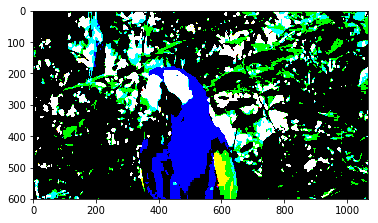

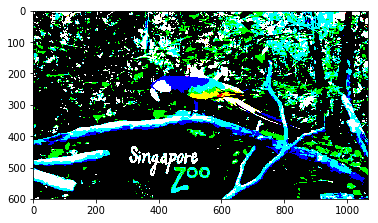

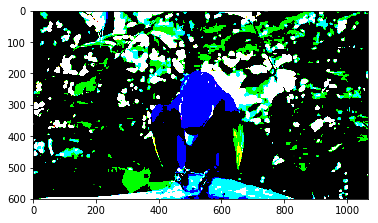

tensor([[  600.0000,  1067.0000,     0.8333],
        [  600.0000,  1067.0000,     0.8333],
        [  600.0000,  1067.0000,     0.8333]], device='cuda:0')
tensor([[[ 339.1667,  181.6667,  660.0000,  592.5000,    5.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
             0.0000],
         ...,
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
             0.0000]],

        [[ 364.1667,  200.8333,  880.0000,  393.3333,    5.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
             0.0000],
         [   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
             0.0000],
         ...,
         [   0.0000,    0.0000,

In [14]:
im_data.data.resize_(d_1[0].size()).copy_(d_1[0])
im_info.data.resize_(d_1[1].size()).copy_(d_1[1])
gt_boxes.data.resize_(d_1[2].size()).copy_(d_1[2])
num_boxes.data.resize_(d_1[3].size()).copy_(d_1[3])
img1 = im_data[0,:,:,:].cpu().numpy()
img1 = img1.transpose([1,2,0])
plt.imshow(img1)
plt.show()
img2 = im_data[1,:,:,:].cpu().numpy()
img2 = img2.transpose([1,2,0])
plt.imshow(img2)
plt.show()
img3 = im_data[2,:,:,:].cpu().numpy()
img3 = img3.transpose([1,2,0])
plt.imshow(img3)
plt.show()
print(im_info)
print(gt_boxes)

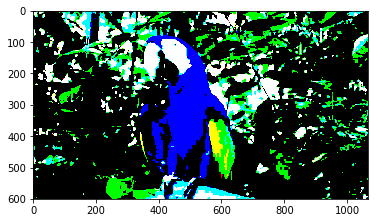

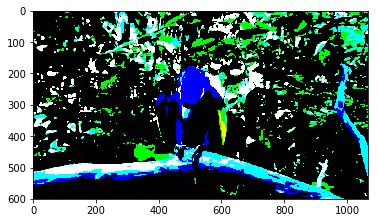

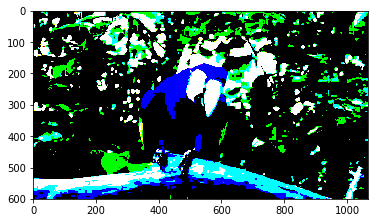

In [13]:
im_data.data.resize_(d_2[0].size()).copy_(d_2[0])
im_info.data.resize_(d_2[1].size()).copy_(d_2[1])
gt_boxes.data.resize_(d_2[2].size()).copy_(d_2[2])
num_boxes.data.resize_(d_2[3].size()).copy_(d_2[3])
img1 = im_data[0,:,:,:].cpu().numpy()
img1 = img1.transpose([1,2,0])
plt.imshow(img1)
plt.show()
img2 = im_data[1,:,:,:].cpu().numpy()
img2 = img2.transpose([1,2,0])
plt.imshow(img2)
plt.show()
img3 = im_data[2,:,:,:].cpu().numpy()
img3 = img3.transpose([1,2,0])
plt.imshow(img3)
plt.show()

#### Examine the trackids for video.

In [21]:
#trackids = [[] for _ in range(1,31)]
#for cat_ind in range(1,31):
#vids = imdb_vid.get_vids_for_category(cat_ind)
#for vid_ind in range(len(vids)):
cat_ind=7
vid_ind = 30
imgs = imdb_vid.get_imgs_for_vid(cat_ind=cat_ind,vid_ind=vid_ind)
anns = [imdb_vid._load_imagenet_annotation(idx) for idx in imgs]
#trackids[cat_ind-1].append(imdb_vid.get_trackids_set_from_anns(anns))
trackids = imdb_vid.get_trackids_set_from_anns(anns)

In [22]:
print(len(imgs))
print(len(anns))
print(trackids)

322
322
set([0, 1, 2])


In [23]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import cv2

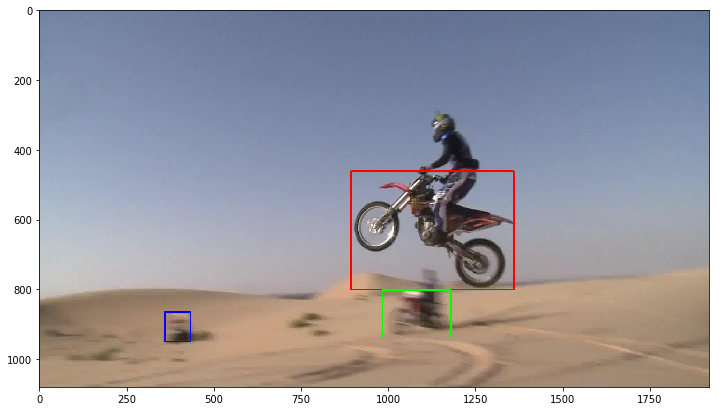

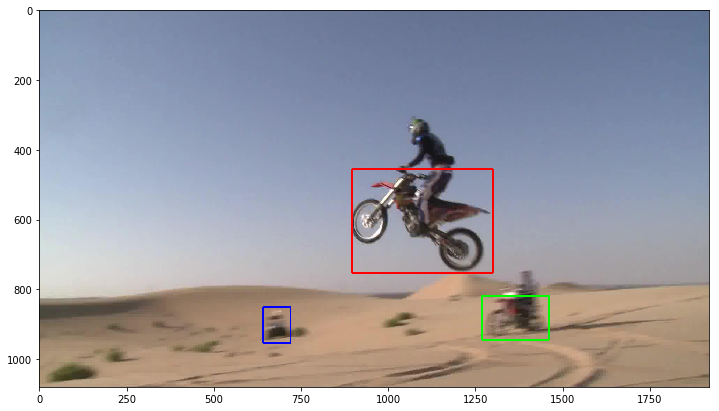

In [24]:
clrs = [(255,0,0),(0,255,0),(0,0,255)]
idx = 235
track_id_sel = [0]
img = np.array(Image.open(imgs[idx]))
ann = anns[idx]
track_ids = ann['trackid']
#print(track_ids)
bboxs = ann['boxes']
plt.figure(figsize=(12,10))
for i in range(len(bboxs)):
    bbox = bboxs[i,:]
    track_id = track_ids[i]
    clr = clrs[track_id]
    x1,y1,x2,y2 = bbox
    img = cv2.rectangle(img,(x1,y1),(x2,y2),clr,3)
plt.imshow(img)
plt.show()

clrs = [(255,0,0),(0,255,0),(0,0,255)]
idx = idx+5
track_id_sel = [0]
img = np.array(Image.open(imgs[idx]))
ann = anns[idx]
track_ids = ann['trackid']
#print(track_ids)
bboxs = ann['boxes']
plt.figure(figsize=(12,10))
for i in range(len(bboxs)):
    bbox = bboxs[i,:]
    track_id = track_ids[i]
    clr = clrs[track_id]
    x1,y1,x2,y2 = bbox
    img = cv2.rectangle(img,(x1,y1),(x2,y2),clr,3)
plt.imshow(img)
plt.show()

#### check validity of the dataset.

In [9]:
for cat_ind in range(1,31):
    vids = imdb_vid.get_vids_for_category(cat_ind)
    for vid_ind in range(len(vids)):
        # assersion is in the function.
        imgs = imdb_vid.get_imgs_for_vid(cat_ind=cat_ind,vid_ind=vid_ind)
        #print(len(imgs))
print('Dataset is okay!')

Dataset is okay!


#### temp test, not important

In [8]:
import torch.nn as nn

In [17]:
class M(nn.Module):
    def __init__(self):
        super(M,self).__init__()
        self.layer_1 = nn.Linear(5,3)
        self.layer_2 = nn.Linear(6,4)
        self.pipe1 = nn.Sequential(*[self.layer_1,self.layer_2])
    def forward(self,x):
        return self.pipe1(x)

In [18]:
M_M = M()

In [27]:
M_M.layer_1.weight[0,0] = 0.0

In [21]:
M_M.layer_2.weight

Parameter containing:
tensor([[ 0.0700,  0.2933, -0.3583, -0.3294, -0.3729,  0.0822],
        [-0.2732, -0.3477, -0.0132,  0.0263, -0.3801, -0.0647],
        [-0.3074,  0.3798,  0.0065,  0.0578, -0.1319,  0.1204],
        [-0.0222,  0.1082,  0.0544,  0.2319, -0.4036, -0.0152]])

In [23]:
print(M_M.pipe1)

Sequential(
  (0): Linear(in_features=5, out_features=3, bias=True)
  (1): Linear(in_features=6, out_features=4, bias=True)
)


In [28]:
M_M.layer_1.weight

Parameter containing:
tensor([[ 0.0000,  0.3997,  0.3059,  0.4150, -0.2187],
        [-0.0309, -0.1657, -0.0173, -0.1354, -0.3674],
        [-0.3963, -0.2307, -0.1919, -0.1360, -0.4434]])

In [29]:
M_M.pipe1[0].weight

Parameter containing:
tensor([[ 0.0000,  0.3997,  0.3059,  0.4150, -0.2187],
        [-0.0309, -0.1657, -0.0173, -0.1354, -0.3674],
        [-0.3963, -0.2307, -0.1919, -0.1360, -0.4434]])

#### Test learnt weight for backpropogation.

In [110]:
def get_CNN_params(model, lr = 0.01):
    params = []
    for key, value in dict(model.named_parameters()).items():
        if value.requires_grad:
            if 'bias' in key:
                params += [{'params': [value], 'lr': lr ,'weight_decay': 0}]
            else:
                params += [{'params': [value], 'lr': lr, 'weight_decay': 0}]
    return params

input = torch.randn((1,5,3,3))
input_w = torch.randn((1,25)).view(-1)
fc = nn.Linear(25,9*5,bias = False)
fc.weight.data.normal_(0., 0.001)

def fowward():
    w = fc(input_w).view(1,5,3,3)
    out = nn.functional.conv2d(input, w, bias=None, stride=3, padding=0, dilation=1, groups=1)
    target = 1.0
    out = out.view(-1)
    loss = (target-out)*(target-out)
    print(out)
    #print(w)
    return loss

def testNNParamerterBackward():
    lr = 0.001
    params = get_CNN_params(conv,lr)+get_CNN_params(fc,lr)
    optimizer = torch.optim.SGD(params, momentum=0.)
    for i in range(10):
        optimizer.zero_grad()
        loss = fowward()
        #print(loss)
        loss.backward()
        optimizer.step()
        
testNNParamerterBackward()

tensor(1.00000e-02 *
       [-2.1043])
tensor([ 0.7958])
tensor([ 0.9592])
tensor([ 0.9918])
tensor([ 0.9984])
tensor([ 0.9997])
tensor([ 0.9999])
tensor([ 1.0000])
tensor([ 1.0000])
tensor([ 1.0000])


#### Test group convolution

In [121]:
input = torch.randn((2,8,20,20))
w = torch.randn((1,8,3,3))
outs = []
for i in range(8):
    out = nn.functional.conv2d(input[:,i:i+1,:,:], w[:,i:i+1,:,:], bias=None, stride=3, padding=0, dilation=1, groups=1)
    outs.append(out)

In [122]:
print(outs[0].shape)

torch.Size([2, 1, 6, 6])


In [129]:
stacked = torch.cat(outs, dim = 1)

In [130]:
print(stacked.shape)

torch.Size([2, 8, 6, 6])


In [131]:
stacked.size(1)

8